In [49]:
%matplotlib inline

# Package and dataset loading

In [50]:
import torch
import torchvision
import torchvision.transforms as transforms
# from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [52]:
# Load GOOG stock data

path = 'data/stock_market_data/GOOG.csv'
data = pd.read_csv(path)

data.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,19-08-2004,2.390042,2.490664,897427216,2.591785,2.499133,2.499133
1,20-08-2004,2.503118,2.515820,458857488,2.716817,2.697639,2.697639
2,23-08-2004,2.716070,2.758411,366857939,2.826406,2.724787,2.724787
3,24-08-2004,2.579581,2.770615,306396159,2.779581,2.611960,2.611960
4,25-08-2004,2.587302,2.614201,184645512,2.689918,2.640104,2.640104


# Data scaling

In [53]:
# Data preprocessing

from sklearn.preprocessing import MinMaxScaler
price = data[['Close']].copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

# Train test val split

In [54]:
# Split data into training and test set with sliding window method

def split_data(stock, lookback, val_size=0.1):
    data_raw = stock.to_numpy()  # Convert to numpy array
    data = []

    # Create sequences of length `lookback`
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    val_set_size = int(np.round(val_size * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size + val_set_size)

    # Split into training, validation, and test sets
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size+val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size+val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:, :-1, :]
    y_test = data[train_set_size+val_set_size:, -1, :]

    return x_train, y_train, x_val, y_val, x_test, y_test

lookback = 20 # choose sequence length
x_train, y_train, x_val, y_val, x_test, y_test = split_data(price, lookback)

# Check shapes
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_val.shape =', x_val.shape)
print('y_val.shape =', y_val.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (3215, 19, 1)
y_train.shape = (3215, 1)
x_val.shape = (459, 19, 1)
y_val.shape = (459, 1)
x_test.shape = (918, 19, 1)
y_test.shape = (918, 1)


# Train model function

In [55]:
# Train the model
import time

def train_model(model, 
                criterion, 
                optimiser, 
                x_train, y_train,
                x_val=None, y_val=None, 
                num_epochs = 100):
    train_loss = []
    val_loss = []
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        optimiser.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
        
        if x_val is not None:
            model.eval()
            with torch.no_grad():
                val_outputs = model(x_val)
                val_epoch_loss = criterion(val_outputs, y_val)
                val_loss.append(val_epoch_loss.item())
        else:
            val_loss.append(None)
            
        if epoch % 10 == 0:
            if x_val is not None:
                print(f'Epoch {epoch}, train loss: {loss.item()}, val loss: {val_epoch_loss.item()}')
            else:
                print(f'Epoch {epoch}, train loss: {loss.item()}')
    
    training_time = time.time() - start_time
    print(f'Training time: {training_time}')
    
    return train_loss, val_loss
    

# RNN model

In [56]:
# Define RNN
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

# LSTM model

In [57]:
# Define LSTM
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

# GRU model

In [58]:
# Define GRU
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :]) 
        return out

# Hyperparameter tuning

In [59]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)

# Hyperparameters defining
input_dim = 1
output_dim = 1

# Tunable hyperparameters
models = [RNN, LSTM, GRU]
hidden_dim = [32, 64, 128]
num_layers = [2, 3]
num_epochs = [100, 200]
learning_rate = [0.01, 0.001, 0.0001]

In [ ]:
# Grid search
tune_start_time = time.time()
results = []
best_model = None
for model in models:
    for h_dim in hidden_dim:
        for n_layers in num_layers:
            for n_epoch in num_epochs:
                for lr in learning_rate:
                    y_train_tune = torch.from_numpy(y_train).type(torch.Tensor)
                    y_val_tune = torch.from_numpy(y_val).type(torch.Tensor)
                    print(f'Training {model.__name__} with hidden_dim={h_dim}, num_layers={n_layers}, num_epochs={n_epoch}, lr={lr}')
                    model_instance = model(input_dim=input_dim, hidden_dim=h_dim, num_layers=n_layers, output_dim=output_dim).to(device)
                    criterion = nn.MSELoss()
                    optimiser = torch.optim.Adam(model_instance.parameters(), lr=lr)
                    train_loss, val_loss = train_model(model_instance, 
                                                       criterion, 
                                                       optimiser, 
                                                       x_train, 
                                                       y_train_tune, 
                                                       x_val = x_val, 
                                                       y_val = y_val_tune, 
                                                       num_epochs=n_epoch)
                        
                    results.append({
                        'model': model.__name__,
                        'hidden_dim': h_dim,
                        'num_layers': n_layers,
                        'num_epochs': n_epoch,
                        'lr': lr,
                        'train_loss': train_loss,
                        'val_loss': val_loss
                    })
tune_time = time.time() - tune_start_time
print(f'Tuning time: {tune_time}')

Training RNN with hidden_dim=32, num_layers=2, num_epochs=100, lr=0.01
Epoch 0, train loss: 0.5176611542701721, val loss: 0.12967555224895477
Epoch 10, train loss: 0.03814549744129181, val loss: 0.29097673296928406
Epoch 20, train loss: 0.021211137995123863, val loss: 0.24434535205364227
Epoch 30, train loss: 0.013555091805756092, val loss: 0.18204212188720703
Epoch 40, train loss: 0.008368130773305893, val loss: 0.09528682380914688
Epoch 50, train loss: 0.0041682240553200245, val loss: 0.01865115389227867
Epoch 60, train loss: 0.005085524637252092, val loss: 0.03639042750000954
Epoch 70, train loss: 0.0006712671602144837, val loss: 0.018145635724067688
Epoch 80, train loss: 0.00044841435737907887, val loss: 0.0015860969433560967
Epoch 90, train loss: 0.00011557993275346234, val loss: 0.0032537037041038275
Training time: 3.0275866985321045
Training RNN with hidden_dim=32, num_layers=2, num_epochs=100, lr=0.001
Epoch 0, train loss: 0.4599166512489319, val loss: 0.01790691167116165
Epoch

# Best model training

In [ ]:
# Check best model

results_df = pd.DataFrame(results)
results_df['mse'] = results_df['val_loss'].apply(np.mean)
clean_df = results_df.drop(columns=['train_loss', 'val_loss'])
clean_df.sort_values(by='mse', ascending=True).head()

# Best model should be saved on the loop, but we forgot to do that
# Well just train it again
best_params = clean_df.sort_values(by='mse', ascending=True).iloc[0]

print(best_params)

model              GRU
hidden_dim         128
num_layers           2
num_epochs         200
lr                0.01
mse           0.016456
Name: 99, dtype: object


In [69]:
y_train_best = torch.from_numpy(y_train).type(torch.Tensor)
y_val_best = torch.from_numpy(y_val).type(torch.Tensor)
y_test_best = torch.from_numpy(y_test).type(torch.Tensor)

best_model = GRU(input_dim=input_dim, 
                 hidden_dim=int(best_params['hidden_dim']), 
                 num_layers=int(best_params['num_layers']), 
                 output_dim=output_dim).to(device)
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'])
best_train_loss, best_val_loss = train_model(best_model, 
                                   criterion, 
                                   optimiser, 
                                   x_train, 
                                   y_train_best, 
                                   x_val = x_val, 
                                   y_val = y_val_best, 
                                   num_epochs=best_params['num_epochs'])

Epoch 0, train loss: 0.5482916831970215, val loss: 0.28616562485694885
Epoch 10, train loss: 0.011488945223391056, val loss: 0.21613411605358124
Epoch 20, train loss: 0.01593106985092163, val loss: 0.0930241197347641
Epoch 30, train loss: 0.004130747634917498, val loss: 0.0004102076927665621
Epoch 40, train loss: 9.787076123757288e-05, val loss: 0.00033667549723759294
Epoch 50, train loss: 0.0006327501614578068, val loss: 0.0008724224753677845
Epoch 60, train loss: 6.646248220931739e-05, val loss: 0.0003766904410440475
Epoch 70, train loss: 0.00012982802581973374, val loss: 0.00023985990264918655
Epoch 80, train loss: 7.031921268207952e-05, val loss: 0.00038487190613523126
Epoch 90, train loss: 4.706636173068546e-05, val loss: 0.00021537365682888776
Epoch 100, train loss: 4.0514885768061504e-05, val loss: 0.00023834257444832474
Epoch 110, train loss: 3.712442412506789e-05, val loss: 0.00020494752970989794
Epoch 120, train loss: 3.451237716944888e-05, val loss: 0.0002021667460212484
Epo

# Best model evaluation

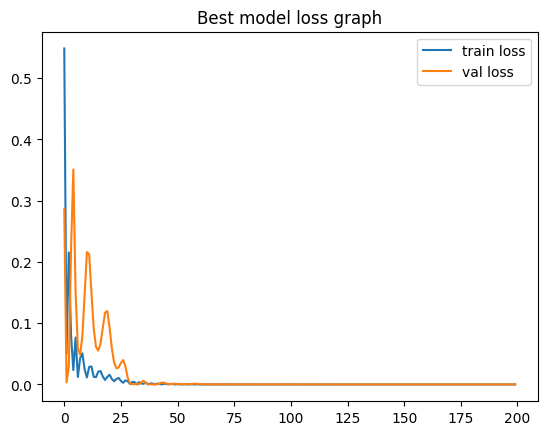

In [71]:
# Plot the best model
plt.plot(best_train_loss, label='train loss')
plt.plot(best_val_loss, label='val loss')
plt.title('Best model loss graph')
plt.legend()
plt.show()

In [72]:
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(x_test)
    test_loss = criterion(test_outputs, y_test_best)
    print(f'Best model MSE: {test_loss.item()}')

Best model MSE: 0.0065247248858213425


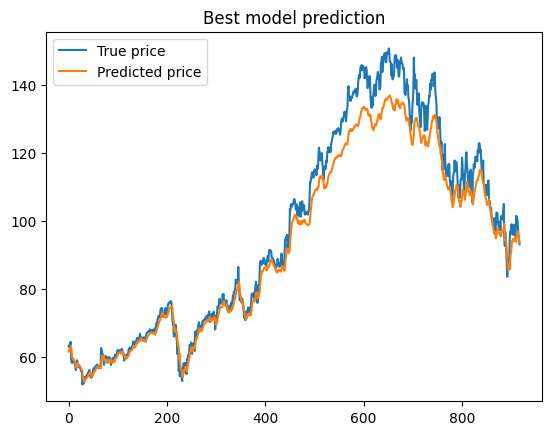

In [75]:
# Descale the data
y_test_descaled = scaler.inverse_transform(y_test_best)
y_test_pred = scaler.inverse_transform(test_outputs)

plt.plot(y_test_descaled, label='True price')
plt.plot(y_test_pred, label='Predicted price')
plt.title('Best model prediction')
plt.legend()
plt.show()
